This is my first end to end machine learning project on housing data. I start with some exploration of the data.

In [12]:
# common imports
import numpy as np
import os

np.random.seed(42)

#plotting

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

#saving the figures

PROJECT_ROOT_DIR = "."
CHAPTER_ID="end_to_end_project"

def save_fig(fig_id,tight_layout=True):
    path=os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID, fig_id +".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format='png', dpi=300)


Loading the data from the source!

In [13]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [14]:
fetch_housing_data()

In [15]:
import pandas as pd

def load_housing_data(housing_path= HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

A sneak peek on what we're dealing with!

In [16]:
housing= load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Checking for skewness, and where all the houses are concentrated. 

In [18]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

This is to just check what each parameter looks like. Max and min values, and the mean values which describe the parameters.

In [19]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Now we graph each parameter, just to check for frequency distributions and any outliers.

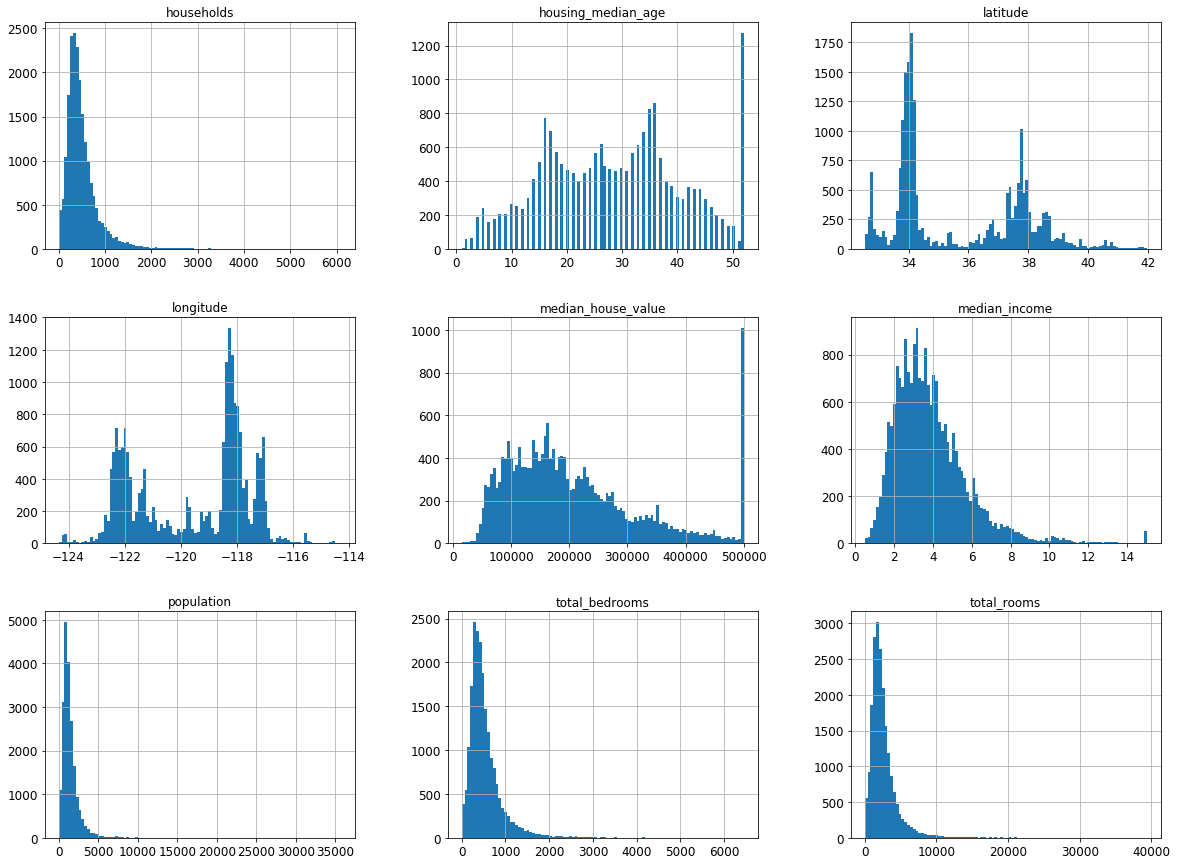

In [20]:
%matplotlib inline
housing.hist(bins=100, figsize=(20,15))
plt.show()


Now we need to split the dataset into a training and a test set. We should split it in a way such that the test set we set aside in the beginning is never trained upon in any instance. 
We could do that by computing the hash of each instance's identifier, keep only the last byte of the hash and put the instance in the test set if this value is lower or equal to 51(~20% of 256). This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset.
The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [21]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately the housing dataset does not have an identifier column. We can use the row index as the ID:

In [22]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [23]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [24]:
from sklearn.model_selection import train_test_split
train_set,testt_set= train_test_split(housing,test_size=0.2, random_state=42)

Looking back, we see that the median income is clustered mostly around the 2-5(tens of thousans of dollars), and some are also beyond 6.The following code creates an income category attribute by dividing the median income by 1.5( to limit the number of income discrete categories), and then merging all the categories greater than 5 into category 5:

In [25]:
housing["income_cat"]= np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

Now we can do stratified sampling based on the income category. We can use Scikit Learn's StratifiedShuffleSplit class:

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
split= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set= housing.loc[train_index]
    strat_test_set= housing.loc[test_index]

In [27]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [28]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

Let's create a copy so that we can play around with the data without actually harming the training set:

In [29]:
housing= strat_train_set.copy()

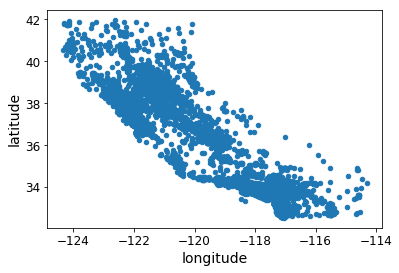

In [30]:
housing.plot(kind="scatter",x="longitude",y="latitude")

We can add an alpha equal to 0.1 to much easily identify the more dense areas:

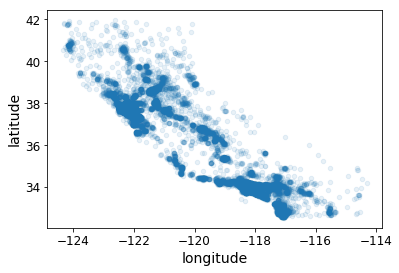

In [31]:
housing.plot(kind="scatter",x="longitude",y="latitude", alpha=0.1)

Now we plot based on house value! Shows us what areas are more expensive.

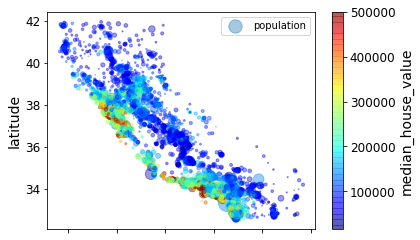

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.4,
            s=housing["population"]/100, label="population",c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

We can now check for correlations between different parameters in the dataset. This checks for the Pearson Correlation Coefficient:

In [33]:
corr_matrix= housing.corr()

In [34]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Now we can plot different parameters against each other to more clearly see any visual correlations

C:\Users\Parth\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000199C3AA1978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000199C39B5390>]], dtype=object)

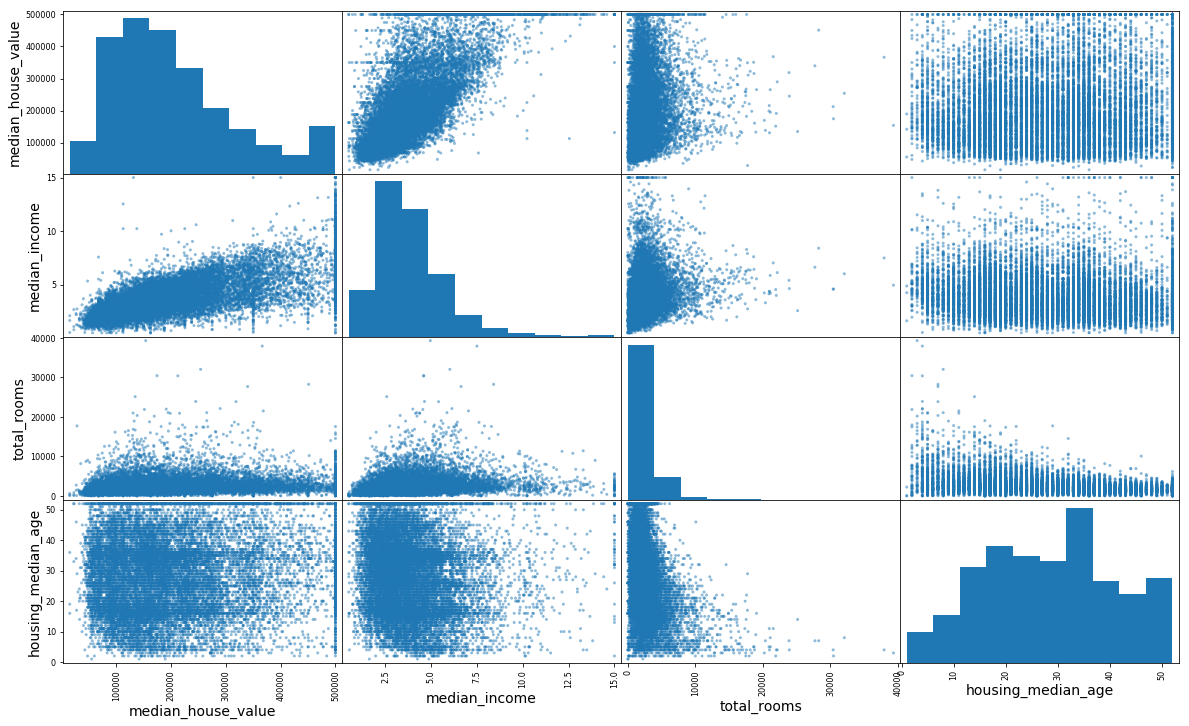

In [35]:
from pandas.tools.plotting import scatter_matrix
attributes= ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(20,12))

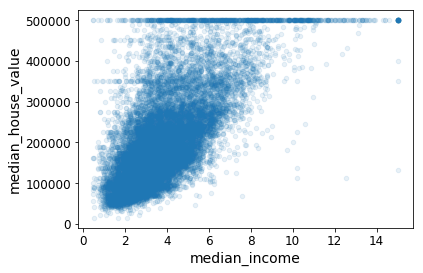

In [36]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

In [37]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]= housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]= housing["population"]/housing["households"]

In [38]:
corr_matrix= housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

The imputer replaces any missing/null values with the median value of each column. 

In [40]:
from sklearn.preprocessing import Imputer
imputer= Imputer(strategy="median")

In [41]:
housing_num=housing.drop("ocean_proximity", axis=1)

In [42]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [43]:
housing_num.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [44]:
imputer.statistics_


array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [45]:
X= imputer.transform(housing_num)

In [46]:
housing_tr= pd.DataFrame(X,columns=housing_num.columns)

In [47]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
5,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395
6,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839
7,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000
8,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242
9,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999


In [48]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing["ocean_proximity"]
housing_cat_encoded=encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [49]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [50]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
housing_cat_hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

In [51]:
housing_cat_hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [52]:
print(housing_cat_hot)

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 1)	1.0
  (16489, 4)	1.0
  (16490, 3)	1.0
  (16491, 0)	1.0
  (16492, 3)	1.0
  (16493, 1)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 3)	1.0
  (16498, 1)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 4)	1.0
  (16503, 0)	1.0
  (16504, 1)	1.0
  (16505, 1)	1.0
  (16506, 0)	1.0
  (16507, 1)	1.0
  (16508, 1)	1.0
  (16509, 1)	1.0
  (16510, 0)	1.0
  (16511, 3)	1.0


In [53]:
from sklearn.preprocessing import LabelBinarizer
>>> encoder = LabelBinarizer()
>>> housing_cat_1hot = encoder.fit_transform(housing_cat)
>>> housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [57]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [58]:
housing_prepped=full_pipeline.fit_transform(housing)
housing_prepped

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [59]:
housing_prepped.shape

(16512, 16)

In [60]:
from sklearn.linear_model import LinearRegression

In [61]:
lin_reg=LinearRegression()
lin_reg.fit(housing_prepped, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepped= full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepped))
print("Labels:\t\t",list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [63]:
from sklearn.metrics import mean_squared_error
>>> housing_predictions = lin_reg.predict(housing_prepped)
>>> lin_mse = mean_squared_error(housing_labels, housing_predictions)
>>> lin_rmse = np.sqrt(lin_mse)
>>> lin_rmse

68628.198198489234

In [64]:
from sklearn.tree import DecisionTreeRegressor
tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepped, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [65]:
housing_preds=tree_reg.predict(housing_prepped)
tree_mse=mean_squared_error(housing_labels, housing_preds)
tree_rmse=np.sqrt(tree_mse)
tree_rmse

0.0

In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepped, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [67]:
def display_scores(scores):
...     print("Scores:", scores)
...     print("Mean:", scores.mean())
...     print("Standard deviation:", scores.std())

In [68]:
display_scores(rmse_scores)

Scores: [ 68292.14894598  66782.53562278  70759.47269143  69889.91977163
  70589.76882605  74182.94790873  71548.27958524  70250.63692186
  76559.98348136  69500.68470599]
Mean: 70835.6378461
Standard deviation: 2654.47566618


In [70]:
lin_scores= cross_val_score(lin_reg,housing_prepped, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [71]:
from sklearn.ensemble import RandomForestRegressor
forest_reg= RandomForestRegressor()
forest_reg.fit(housing_prepped, housing_labels)
housing_preds_1=forest_reg.predict(housing_prepped)
forest_mse=mean_squared_error(housing_labels, housing_preds_1)
forest_rmse=np.sqrt(forest_mse)
forest_rmse


22273.360483461016

In [72]:
forest_scores=cross_val_score(forest_reg, housing_prepped,housing_labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores= np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52358.66679404  49743.79903788  51335.21486934  54925.88657132
  52257.98169035  55720.86291923  52842.69505175  50082.9703802
  55483.30713101  53171.12873845]
Mean: 52792.2513184
Standard deviation: 1993.65740926


In [74]:
from sklearn.externals import joblib

joblib.dump(forest_reg, "my_model.pkl")


['my_model.pkl']

In [76]:
from sklearn.model_selection import GridSearchCV
param_grid=[{
    'n_estimators':[3,10,30], 'max_features':[2,4,6,8]
},
{'bootstrap':[False], 'n_estimators':[3,10],
 'max_features':[2,3,4]
    
}]

grid_search= GridSearchCV(forest_reg, param_grid, cv=5,
                         scoring='neg_mean_squared_error')
grid_search.fit(housing_prepped, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'bootstrap': [False], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [77]:
grid_search.best_params_


{'max_features': 6, 'n_estimators': 30}

In [79]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [80]:
cvres=grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

64622.6722294 {'n_estimators': 3, 'max_features': 2}
55508.7926147 {'n_estimators': 10, 'max_features': 2}
53014.5656175 {'n_estimators': 30, 'max_features': 2}
60348.2876975 {'n_estimators': 3, 'max_features': 4}
52705.0213752 {'n_estimators': 10, 'max_features': 4}
50583.822279 {'n_estimators': 30, 'max_features': 4}
58167.9139019 {'n_estimators': 3, 'max_features': 6}
52439.4168455 {'n_estimators': 10, 'max_features': 6}
49800.6023307 {'n_estimators': 30, 'max_features': 6}
59188.3300189 {'n_estimators': 3, 'max_features': 8}
52257.1592105 {'n_estimators': 10, 'max_features': 8}
50136.5064742 {'n_estimators': 30, 'max_features': 8}
62952.8794716 {'n_estimators': 3, 'bootstrap': False, 'max_features': 2}
54594.9968203 {'n_estimators': 10, 'bootstrap': False, 'max_features': 2}
59595.0825759 {'n_estimators': 3, 'bootstrap': False, 'max_features': 3}
52577.9037875 {'n_estimators': 10, 'bootstrap': False, 'max_features': 3}
58672.0278279 {'n_estimators': 3, 'bootstrap': False, 'max_feat

In [81]:
feature_importances= grid_search.best_estimator_.feature_importances_
feature_importances

array([  8.46623290e-02,   7.34277519e-02,   4.11193221e-02,
         1.80185871e-02,   1.59803438e-02,   1.75937575e-02,
         1.59035060e-02,   3.21416841e-01,   6.40964788e-02,
         1.07047245e-01,   5.99590057e-02,   2.08033651e-02,
         1.49890974e-01,   4.17814494e-05,   5.44787380e-03,
         4.59083738e-03])

In [82]:
extra_attribs=["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
cat_one_hot_attribs=list(encoder.classes_)
attributes= num_attribs +extra_attribs +cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32141684084274375, 'median_income'),
 (0.14989097419533737, 'INLAND'),
 (0.10704724535639938, 'pop_per_hhold'),
 (0.084662329015982446, 'longitude'),
 (0.073427751879875533, 'latitude'),
 (0.064096478798103249, 'rooms_per_hhold'),
 (0.059959005675432907, 'bedrooms_per_room'),
 (0.0411193221028162, 'housing_median_age'),
 (0.020803365111524794, '<1H OCEAN'),
 (0.018018587120756983, 'total_rooms'),
 (0.017593757464570588, 'population'),
 (0.015980343769714488, 'total_bedrooms'),
 (0.015903506041215779, 'households'),
 (0.0054478737988722069, 'NEAR BAY'),
 (0.0045908373772918674, 'NEAR OCEAN'),
 (4.1781449362410541e-05, 'ISLAND')]

In [83]:
final_model= grid_search.best_estimator_
X_test= strat_test_set.drop("median_house_value", axis=1)
y_test=strat_test_set["median_house_value"].copy()
X_test_prepped= full_pipeline.transform(X_test)

final_predictions= final_model.predict(X_test_prepped)
final_mse= mean_squared_error(y_test,final_predictions)
final_rmse= np.sqrt(final_mse)

In [84]:
final_rmse

47414.930132678455

There it is! Our best estimator is the Random Forest Regressor with max_features=6, and number of estimators=30. We can always try using more estimators,it will obviously take more time to compute but when run on a cloud server, may end up giving better results. 
